### Importing Important Libraries

# An Introduction to Linear Learner with MNIST
_**Making a Binary Prediction of Whether a Handwritten Digit is a 0**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
   1. [Permissions and environment variables](#Permissions-and-environment-variables)
   2. [Data ingestion](#Data-ingestion)
   3. [Data inspection](#Data-inspection)
   4. [Data conversion](#Data-conversion)
3. [Training the linear model](#Training-the-linear-model)
   1. [Training the Linear Learner model with SageMaker Training](#Training-with-sagemaker-training)
   2. [Training with Automatic Model Tuning (HPO)](#Training-with-automatic-model-tuning-HPO)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)

In [1]:
pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.4/592.4 KB 6.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 51.7 MB/s eta 0:00:0000:0100:01
  Created wheel for sagemaker: filename=sagemaker-2.117.0-py2.py3-none-any.whl size=809089 sha256=788652d115243eb8c61b6fbe4f9e7064365293276ffe47b1472818f8223951b9
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/15/35/16fa5712cc84469c59f69686f6d5f300dafb2a023838f5aff3
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.116.0
    Uninstalling sagemaker-2.116.0:
      Successfully uninstalled sagemaker-2.116.0
ERROR: pip's dependency resolver does not currently ta

In [2]:
import re
import boto3
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

region = boto3.Session().region_name

# S3 bucket where the original mnist data is downloaded and stored.
downloaded_data_bucket = f"sagemaker-sample-files"
downloaded_data_prefix = "datasets/image/MNIST"

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sess.default_bucket()
prefix = "sagemaker/DEMO-linear-mnist"

# Define IAM role
role = get_execution_role()
print(role)

arn:aws:iam::045659353622:role/service-role/AmazonSageMaker-ExecutionRole-20221129T105980


In [3]:
print(region)

us-east-1


### Data ingestion

Next, we read the MNIST dataset [1] from an existing repository into memory, for preprocessing prior to training. It was downloaded from this [link](http://deeplearning.net/data/mnist/mnist.pkl.gz) and stored on the `downloaded_data_bucket`. Processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.
> [1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

In [4]:
%%time
import pickle, gzip, numpy, json

# Load the dataset
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
print("done")    

done
CPU times: user 808 ms, sys: 409 ms, total: 1.22 s
Wall time: 1.42 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

done


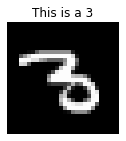

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot is None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], f"This is a {train_set[1][30]}")
print("done") 

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [6]:
import io
import numpy as np
import sagemaker.amazon.common as smac

train_set_vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
train_set_labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype(
    "float32"
)

validation_set_vectors = np.array([t.tolist() for t in valid_set[0]]).astype("float32")
validation_set_labels = np.where(np.array([t.tolist() for t in valid_set[1]]) == 0, 1, 0).astype(
    "float32"
)

train_set_buf = io.BytesIO()
validation_set_buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(train_set_buf, train_set_vectors, train_set_labels)
smac.write_numpy_to_dense_tensor(validation_set_buf, validation_set_vectors, validation_set_labels)
train_set_buf.seek(0)
validation_set_buf.seek(0)
print("done")

done


## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [7]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(
    train_set_buf
)
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "validation", key)).upload_fileobj(
    validation_set_buf
)
s3_train_data = f"s3://{bucket}/{prefix}/train/{key}"
print(f"uploaded training data location: {s3_train_data}")
s3_validation_data = f"s3://{bucket}/{prefix}/validation/{key}"
print(f"uploaded validation data location: {s3_validation_data}")

uploaded training data location: s3://sagemaker-us-east-1-045659353622/sagemaker/DEMO-linear-mnist/train/recordio-pb-data
uploaded validation data location: s3://sagemaker-us-east-1-045659353622/sagemaker/DEMO-linear-mnist/validation/recordio-pb-data


In [8]:
output_location = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts will be uploaded to: {output_location}")

training artifacts will be uploaded to: s3://sagemaker-us-east-1-045659353622/sagemaker/DEMO-linear-mnist/output


## Training the linear model

In [9]:
from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
deploy_amt_model = True

Notice:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

In [10]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200)

linear.fit({"train": s3_train_data})
print("done")

2022-11-29 04:27:36 Starting - Starting the training job...
2022-11-29 04:28:02 Starting - Preparing the instances for trainingProfilerReport-1669696056: InProgress
......
2022-11-29 04:29:06 Downloading - Downloading input data...
2022-11-29 04:29:31 Training - Downloading the training image.........
2022-11-29 04:31:07 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/29/2022 04:31:10 INFO 139795919841088] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bia

### Training with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***

The tuning job will take 8 to 10 minutes to complete.
***

In [11]:
import time
from sagemaker.tuner import IntegerParameter, ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

job_name = "DEMO-ll-mni-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Tuning job name:", job_name)

# Linear Learner tunable hyper parameters can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html
hyperparameter_ranges = {
    "wd": ContinuousParameter(1e-7, 1, scaling_type="Auto"),
    "learning_rate": ContinuousParameter(1e-5, 1, scaling_type="Auto"),
    "mini_batch_size": IntegerParameter(100, 2000, scaling_type="Auto"),
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2


hp_tuner = HyperparameterTuner(
    linear,
    "validation:binary_f_beta",
    hyperparameter_ranges,
    max_jobs=max_jobs,
    max_parallel_jobs=max_parallel_jobs,
    objective_type="Maximize",
)


# Launch a SageMaker Tuning job to search for the best hyperparameters
hp_tuner.fit(inputs={"train": s3_train_data, "validation": s3_validation_data}, job_name=job_name)
print("done")

Tuning job name: DEMO-ll-mni-2022-11-29-04-35-31
...........................................................................................!
done


## Set up hosting for the model

In [12]:
if deploy_amt_model:
    linear_predictor = hp_tuner.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
else:
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


2022-11-29 04:42:50 Starting - Found matching resource for reuse
2022-11-29 04:42:50 Downloading - Downloading input data
2022-11-29 04:42:50 Training - Training image download completed. Training in progress.
2022-11-29 04:42:50 Uploading - Uploading generated training model
2022-11-29 04:42:50 Completed - Resource retained for reuse
--------!

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [13]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()
print("done")

done


Now let's try getting a prediction for a single record.

In [14]:
result = linear_predictor.predict(train_set[0][30:31], initial_args={"ContentType": "text/csv"})
print(result)

{'predictions': [{'score': 1.9693807294919348e-30, 'predicted_label': 0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a continuous value between [0, 1] representing the probability we think the digit is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the image is a 0, while `0` denotes that we are predicting the image is not of a 0.

Let's do a whole batch of images and evaluate our predictive accuracy.

In [15]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [16]:
print(predictions)

[0 0 0 ... 0 0 0]


In [17]:
import pandas as pd

pd.crosstab(
    np.where(test_set[1] == 0, 1, 0), predictions, rownames=["actuals"], colnames=["predictions"]
)

predictions,0,1
actuals,,
0,8962,58
1,42,938


As we can see from the confusion matrix above, we predict 931 images of 0 correctly, while we predict 44 images as 0s that aren't, and miss predicting 49 images of 0.

#### Deleting The Endpoints

In [ ]:
linear_predictor.delete_model()
linear_predictor.delete_endpoint()